Install Dependencies

In [24]:
# !pip3 install torchrl
# !pip3 install tqdm

In [25]:
# !wget -P /root/.mujoco https://mujoco.org/file/mujoco237-linux-x86_64.tar.gz
# !tar -xf /root/.mujoco/mujoco237-linux-x86_64.tar.gz -C /root/.mujoco
# !ln -s /root/.mujoco/mujoco237-linux-x86_64 /root/.mujoco/mujoco
# !echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/root/.mujoco/mujoco/bin' >> /root/.bashrc
# !pip install mujoco

Import

In [26]:
import warnings
warnings.filterwarnings("ignore")
from torch import multiprocessing


from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,
                          TransformedEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

# Define Hyperparameters
We set the hyperparameters for our algorithm. Depending on the resources available, one may choose to execute the policy on GPU or on another device. The frame_skip will control how for how many frames is a single action being executed. The rest of the arguments that count frames must be corrected for this value (since one environment step will actually return frame_skip frames).

In [27]:
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
num_cells = 256  # number of cells in each layer i.e. output dim.
lr = 3e-4
max_grad_norm = 1.0

# Data collection parameters
When collecting data, we will be able to choose how big each batch will be by defining a frames_per_batch parameter. We will also define how many frames (such as the number of interactions with the simulator) we will allow ourselves to use. In general, the goal of an RL algorithm is to learn to solve the task as fast as it can in terms of environment interactions: the lower the total_frames the better.

In [28]:
frames_per_batch = 1000
# For a complete training, bring the number of frames up to 1M
total_frames = 50_000

# PPO parameters
At each data collection (or batch collection) we will run the optimization over a certain number of epochs, each time consuming the entire data we just acquired in a nested training loop. Here, the sub_batch_size is different from the frames_per_batch here above: recall that we are working with a “batch of data” coming from our collector, which size is defined by frames_per_batch, and that we will further split in smaller sub-batches during the inner training loop. The size of these sub-batches is controlled by sub_batch_size.

In [29]:
sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimization steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

# Define an environment
In RL, an environment is usually the way we refer to a simulator or a control system. Various libraries provide simulation environments for reinforcement learning, including Gymnasium (previously OpenAI Gym), DeepMind control suite, and many others. As a general library, TorchRL’s goal is to provide an interchangeable interface to a large panel of RL simulators, allowing you to easily swap one environment with another. For example, creating a wrapped gym environment can be achieved with few characters:

In [32]:
base_env = GymEnv("InvertedDoublePendulum-v4", device=device)

ImportError: could not set anything related to gym backend gymnasium with version=0.26.1 for the function with name torchrl.envs.libs.gym.GymWrapper._make_done_spec. Check that the gym versions match!

# Normalization
The first to encode is a normalization transform. As a rule of thumbs, it is preferable to have data that loosely match a unit Gaussian distribution: to obtain this, we will run a certain number of random steps in the environment and compute the summary statistics of these observations.

We’ll append two other transforms: the DoubleToFloat transform will convert double entries to single-precision numbers, ready to be read by the policy. The StepCounter transform will be used to count the steps before the environment is terminated. We will use this measure as a supplementary measure of performance.

As we will see later, many of the TorchRL’s classes rely on TensorDict to communicate. You could think of it as a python dictionary with some extra tensor features. In practice, this means that many modules we will be working with need to be told what key to read (in_keys) and what key to write (out_keys) in the tensordict they will receive. Usually, if out_keys is omitted, it is assumed that the in_keys entries will be updated in-place. For our transforms, the only entry we are interested in is referred to as "observation" and our transform layers will be told to modify this entry and this entry only:

In [ ]:
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(),
        StepCounter(),
    ),
)

NameError: name 'base_env' is not defined

In [ ]:
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)

In [ ]:
print("normalization constant shape:", env.transform[0].loc.shape)

normalization constant shape: torch.Size([11])


In [ ]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

observation_spec: Composite(
    observation: UnboundedContinuous(
        shape=torch.Size([11]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([11]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([11]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    step_count: BoundedDiscrete(
        shape=torch.Size([1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True),
            high=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True)),
        device=cpu,
        dtype=torch.int64,
        domain=discrete),
    device=cpu,
    shape=torch.Size([]),
    data_cls=None)
reward_spec: UnboundedContinuous(
    shape=torch.Size([1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True),

the check_env_specs() function runs a small rollout and compares its output against the environment specs. If no error is raised, we can be confident that the specs are properly defined:

In [ ]:
check_env_specs(env)

2025-09-13 20:16:03,961 [torchrl][INFO]    check_env_specs succeeded! [END]


For fun, let’s see what a simple random rollout looks like. You can call env.rollout(n_steps) and get an overview of what the environment inputs and outputs look like. Actions will automatically be drawn from the action spec domain, so you don’t need to care about designing a random sampler.

Typically, at each step, an RL environment receives an action as input, and outputs an observation, a reward and a done state. The observation may be composite, meaning that it could be composed of more than one tensor. This is not a problem for TorchRL, since the whole set of observations is automatically packed in the output TensorDict. After executing a rollout (for example, a sequence of environment steps and random action generations) over a given number of steps, we will retrieve a TensorDict instance with a shape that matches this trajectory length:

In [ ]:
rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([3, 11]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                step_count: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.int64, is_shared=False),
                terminated: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([3]),
            devi

# Policy
PPO utilizes a stochastic policy to handle exploration. This means that our neural network will have to output the parameters of a distribution, rather than a single value corresponding to the action taken.

As the data is continuous, we use a Tanh-Normal distribution to respect the action space boundaries. TorchRL provides such distribution, and the only thing we need to care about is to build a neural network that outputs the right number of parameters for the policy to work with (a location, or mean, and a scale):

f
θ
(
observation
)
=
μ
θ
(
observation
)
,
σ
θ
+
(
observation
)
f
θ
​
 (observation)=μ
θ
​
 (observation),σ
θ
+
​
 (observation)
The only extra-difficulty that is brought up here is to split our output in two equal parts and map the second to a strictly positive space.

We design the policy in three steps:

Define a neural network D_obs -> 2 * D_action. Indeed, our loc (mu) and scale (sigma) both have dimension D_action.

Append a NormalParamExtractor to extract a location and a scale (for example, splits the input in two equal parts and applies a positive transformation to the scale parameter).

Create a probabilistic TensorDictModule that can generate this distribution and sample from it.

In [ ]:
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

To enable the policy to “talk” with the environment through the tensordict data carrier, we wrap the nn.Module in a TensorDictModule. This class will simply ready the in_keys it is provided with and write the outputs in-place at the registered out_keys.

In [ ]:
policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)

The name of the in_keys (and hence the name of the out_keys from the TensorDictModule above) cannot be set to any value one may like, as the TanhNormal distribution constructor will expect the loc and scale keyword arguments. That being said, ProbabilisticActor also accepts Dict[str, str] typed in_keys where the key-value pair indicates what in_key string should be used for every keyword argument that is to be used.

In [ ]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "low": env.action_spec.space.low,
        "high": env.action_spec.space.high,
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

#Value network
The value network is a crucial component of the PPO algorithm, even though it won’t be used at inference time. This module will read the observations and return an estimation of the discounted return for the following trajectory. This allows us to amortize learning by relying on the some utility estimation that is learned on-the-fly during training. Our value network share the same structure as the policy, but for simplicity we assign it its own set of parameters.

In [ ]:
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

In [ ]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        action_log_prob: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        loc: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        observation: Tensor(shape=torch.Size([11]), device=cpu, dtype=torch.float32, is_shared=False),
        scale: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        step_count: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)
Running v

#Data collector
TorchRL provides a set of DataCollector classes. Briefly, these classes execute three operations: reset an environment, compute an action given the latest observation, execute a step in the environment, and repeat the last two steps until the environment signals a stop (or reaches a done state).

They allow you to control how many frames to collect at each iteration (through the frames_per_batch parameter), when to reset the environment (through the max_frames_per_traj argument), on which device the policy should be executed, etc. They are also designed to work efficiently with batched and multiprocessed environments.

The simplest data collector is the SyncDataCollector: it is an iterator that you can use to get batches of data of a given length, and that will stop once a total number of frames (total_frames) have been collected. Other data collectors (MultiSyncDataCollector and MultiaSyncDataCollector) will execute the same operations in synchronous and asynchronous manner over a set of multiprocessed workers.

As for the policy and environment before, the data collector will return TensorDict instances with a total number of elements that will match frames_per_batch. Using TensorDict to pass data to the training loop allows you to write data loading pipelines that are 100% oblivious to the actual specificities of the rollout content.

In [ ]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

# Replay buffer
Replay buffers are a common building piece of off-policy RL algorithms. In on-policy contexts, a replay buffer is refilled every time a batch of data is collected, and its data is repeatedly consumed for a certain number of epochs.

TorchRL’s replay buffers are built using a common container ReplayBuffer which takes as argument the components of the buffer: a storage, a writer, a sampler and possibly some transforms. Only the storage (which indicates the replay buffer capacity) is mandatory. We also specify a sampler without repetition to avoid sampling multiple times the same item in one epoch. Using a replay buffer for PPO is not mandatory and we could simply sample the sub-batches from the collected batch, but using these classes make it easy for us to build the inner training loop in a reproducible way.

In [ ]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

#Loss function
The PPO loss can be directly imported from TorchRL for convenience using the ClipPPOLoss class. This is the easiest way of utilizing PPO: it hides away the mathematical operations of PPO and the control flow that goes with it.

PPO requires some “advantage estimation” to be computed. In short, an advantage is a value that reflects an expectancy over the return value while dealing with the bias / variance tradeoff. To compute the advantage, one just needs to (1) build the advantage module, which utilizes our value operator, and (2) pass each batch of data through it before each epoch. The GAE module will update the input tensordict with new "advantage" and "value_target" entries. The "value_target" is a gradient-free tensor that represents the empirical value that the value network should represent with the input observation. Both of these will be used by ClipPPOLoss to return the policy and value losses.

In [ ]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True, device=device,
)

loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

/usr/local/lib/python3.12/dist-packages/torchrl/objectives/ppo.py:384: DeprecationWarning: 'critic_coef' is deprecated and will be removed in torchrl v0.11. Please use 'critic_coeff' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchrl/objectives/ppo.py:450: DeprecationWarning: 'entropy_coef' is deprecated and will be removed in torchrl v0.11. Please use 'entropy_coeff' instead.
  warnings.warn(


#Training loop
We now have all the pieces needed to code our training loop. The steps include:

* Collect data

  * Compute advantage

    * Loop over the collected to compute loss values

    * Back propagate

    * Optimize

    * Repeat

  * Repeat

* Repeat

In [ ]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.DETERMINISTIC), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()

eval cumulative reward:  539.8768 (init:  157.7083), eval step-count: 57, average reward= 9.3162 (init= 9.0899), step count (max): 122, lr policy:  0.0000: 100%|██████████| 50000/50000 [04:19<00:00, 200.20it/s]

# Results
Before the 1M step cap is reached, the algorithm should have reached a max step count of 1000 steps, which is the maximum number of steps before the trajectory is truncated.

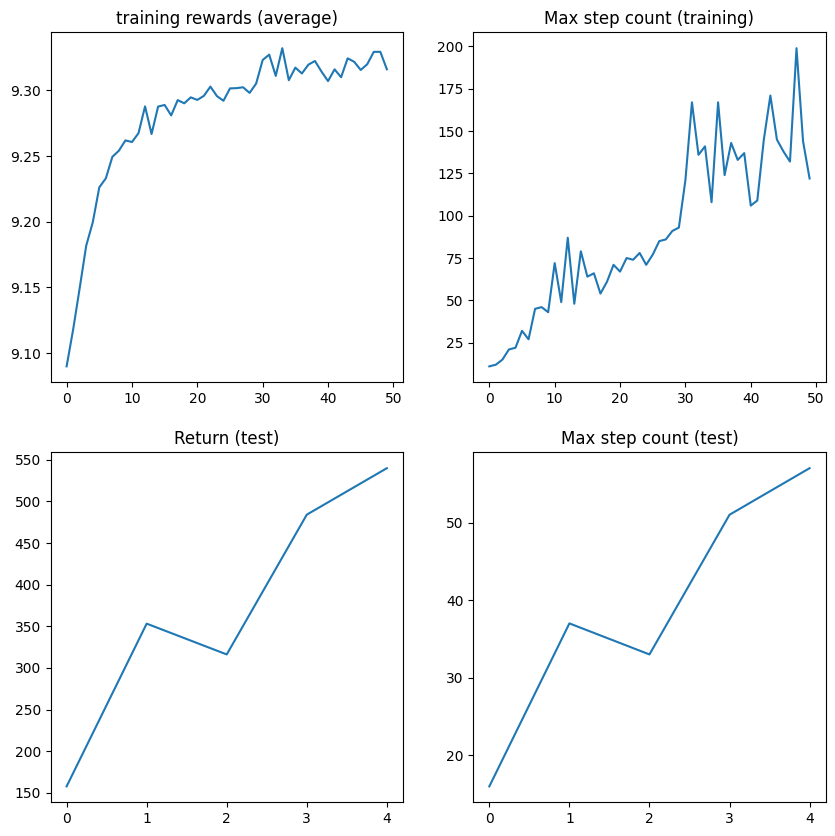

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()